In [1]:
import numpy as np
import scipy
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts
matplotlib.rcParams['mathtext.fontset'] ='stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.weight"] = "bold"

In [2]:
import cudaq
from cudaq import spin
from Sampling_Circuits import *
from MCMC_Proposals import *
from qiskit_circuits import *

In [44]:
N = 20
k=4
J = np.random.randn(N*N)
l = np.random.randn(N)

alpha = 0.5
gamma = 1.0
time_delta = 0.5

angle_list = []
for qubit in range(N):
    coeff = -alpha*(1-gamma)*l[N-1-qubit]
    one_body_Ham = gamma * spin.x(0) + coeff * spin.z(0)
    angle_list.append(list(Euler_angle_decomposition(scipy.linalg.expm(-1.0j*time_delta*one_body_Ham.to_matrix()))))   # always 2*2 so no problem of exponentiation, storage

theta = np.zeros(N)
phi = np.zeros(N)
lam = np.zeros(N)
for qubit in range(N):
    theta[qubit], phi[qubit], lam[qubit] = angle_list[qubit]


In [45]:

# tm = time.time()
# for i in range(100):
#     init_config = np.random.choice([1.0,-1.0], size=N)
#     counts = cudaq.sample(Trotter_circuit, N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1)
# print(time.time()-tm)

# tm = time.time()
# for i in range(100):
#     init_config = np.random.choice([1.0,-1.0], size=N)
#     count_build = Trotter_circuit_builder(N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1)
# print(time.time()-tm)



from qiskit_aer import AerSimulator  

tm = time.time()
for i in range(100):
    init_config = np.random.choice([1.0,-1.0], size=N)
    circuit = Trotter_circuit_qiskit(N, k, alpha, gamma, time_delta, theta, phi, lam, J.reshape((N,N)), init_config)
    circuit.measure_all()

    simulator = AerSimulator(method="matrix_product_state")
    simulator.set_options(matrix_product_state_max_bond_dimension=16)  

    #simulator = AerSimulator(method='tensor_network', device='GPU')
    #simulator = AerSimulator()

    result = simulator.run(circuit, shots=1).result()
    counts = result.get_counts(circuit)

print(time.time()-tm)

2.3447368144989014


NameError: name 'count_build' is not defined

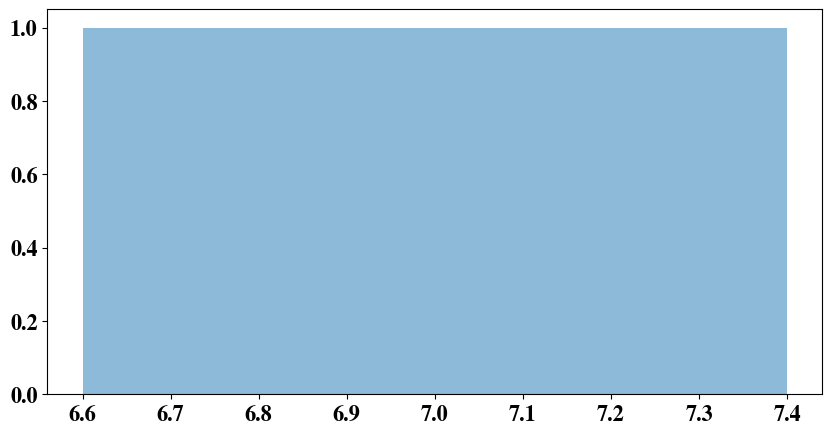

In [7]:
plt.figure(figsize=(10, 5))

bitstrings = []
frequencies = []

for key, value in counts.items():  # CUDA-Q result is an iterable
    bitstrings.append(int(key,2))
    frequencies.append(value)

plt.bar(bitstrings, frequencies, alpha=0.5)
#plt.show()

#plt.figure(figsize=(10, 5))
bitstrings = []
frequencies = []

for key, value in count_build.items():  # CUDA-Q result is an iterable
    bitstrings.append(int(key,2))
    frequencies.append(value)

plt.bar(bitstrings, frequencies,alpha=0.5)



In [ ]:
# for key, value in counts.items():
#     print(key,value)

In [ ]:
def get_operator(kernel):
    num_qubits = 2
    N = 2**num_qubits
    U = np.zeros((N, N), dtype=np.complex128)
    params = [1 ,2]

    for j in range(N):
        state_j    = np.zeros((N), dtype=np.complex128)
        state_j[j] = 1.0
        U[:, j] = np.array(cudaq.get_state(kernel, params, state_j), copy=False)
    print(U)

#get_operator()

In [ ]:
n=no_spins=4
seed=10
np.random.seed(seed)
inverse_temp=beta=1.0
one_body_coeffs = np.random.rand(n)
two_body_coeffs = np.random.rand(n**2)

Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
                                two_body_coeffs = 0.5*two_body_coeffs + 0.5*np.reshape((np.reshape(two_body_coeffs, (n,n)).T), n**2))

alpha = Proposal_object.computing_norm_ratio()
#time_array, time_delta_step = self.scalar_time_sampling(sampling_type="discrete")
time_delta_step = 0.5
#gamma_array, gamma_step = self.scalar_gamma_sampling(sampling_type="discrete")
gamma = 0.42
time = 12
    
counts = cudaq.sample(Trotter_circuit, N, k, alpha, gamma, time_delta, theta, phi, lam, J, init_config, shots_count=1)

1.0709543791732428


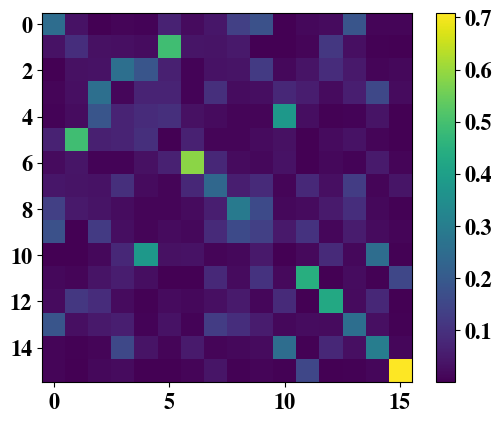

abs spectral gap of quantum T matrix 0.13909005487381298


In [ ]:
n=no_spins=4
seed=10
np.random.seed(seed)
inverse_temp=beta=1.0
one_body_coeffs = np.random.rand(n)
two_body_coeffs = np.random.rand(n**2)

Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
                                two_body_coeffs = 0.5*two_body_coeffs + 0.5*np.reshape((np.reshape(two_body_coeffs, (n,n)).T), n**2))

#print(Proposal_object.model_instance_one_body, Proposal_object.model_instance_two_body)
Proposal_object.get_energy_array().Energy_array

alpha = Proposal_object.computing_norm_ratio()
print(alpha)

#print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="continuous"))
#print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="discrete"))
# print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.5, sampling_type="continuous"))
#print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.2, sampling_type="discrete"))
prop_exact = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Exact-no Trotter error/no Sampling error")
#print(prop_exact)

plt.imshow(np.real(prop_exact))
plt.colorbar()
plt.show()

#prop_Trotter = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Trotter error/no Sampling error")
#print(prop_Trotter)
#print("norm diff between exact and Trotter", np.linalg.norm(prop_exact - prop_Trotter))
Transition_mat=Proposal_object.get_transition_matrix_from_proposal(prop_exact, acceptance_criteria='metropolis')
print("abs spectral gap of quantum T matrix",Proposal_object.get_abs_spectral_gap_from_transition_mat(Transition_mat))

[0.77132064 0.02075195 0.63364823 0.74880388] [[0.49850701 0.19695374 0.10100557 0.74114301]
 [0.19695374 0.08833981 0.59877604 0.62263471]
 [0.10100557 0.59877604 0.81262096 0.76515009]
 [0.74114301 0.62263471 0.76515009 0.71457578]]


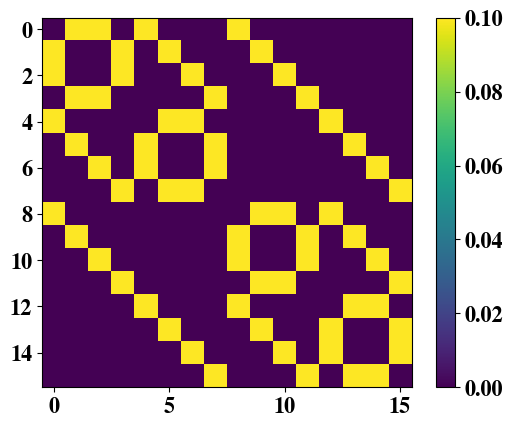

1.0709543791732428
E_array [ 5.99084519 -1.02725831  1.39841486  0.50151211  0.35889113 -1.67813471
  0.55666912  4.64084404  3.37707719  2.28811781 -0.40730862  4.62493275
 -0.67924694  3.21287134  0.32657558 10.33989461]
(0.7997720916201615, -1.5285178425412336, 1.6130748110485595)


In [ ]:
n=no_spins=4
seed=10
np.random.seed(seed)
inverse_temp=beta=1.0
one_body_coeffs = np.random.rand(n)
two_body_coeffs = np.random.rand(n**2)

Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
                                two_body_coeffs = 0.5*two_body_coeffs + 0.5*np.reshape((np.reshape(two_body_coeffs, (n,n)).T), n**2))

print(Proposal_object.model_instance_one_body, Proposal_object.model_instance_two_body)

H = Proposal_object.Learner_Ham_maker_w_wo_mixer(gamma=0.1, alpha=5.0, type_of_Ham="with_mixer").Learner_Ham_w_wo_mixer
H = np.array(H.to_matrix())
np.fill_diagonal(H, 0)

plt.imshow(np.real(H))
plt.colorbar()
plt.show()

alpha = Proposal_object.computing_norm_ratio()
print(alpha)
# print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="continuous"))
# print(Proposal_object.scalar_gamma_sampling(gamma_limits=(0.25,0.6), seed=10, sampling_type="discrete"))
# print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.5, sampling_type="continuous"))
# print(Proposal_object.scalar_time_sampling(time_limits=(4,20), seed=10, time_delta=0.5, sampling_type="discrete"))

print("E_array",Proposal_object.get_energy_array().Energy_array)

mat = 0.5 * spin.x(0) + 0.05 * spin.z(0)
mat = np.array(mat.to_matrix())
print(Euler_angle_decomposition(scipy.linalg.expm(-1.0j*0.8*mat)))

#circuit = Proposal_object.Trotter_circuit(Trotter_repeat_length=6, alpha=alpha, gamma=0.1, time_delta=0.8, initial_config=None)
# circuit = QuantumCircuit(5, 1)
# circuit = Proposal_object.two_qubit_gate(circuit, angle=0.1, qubit_1=2, qubit_2=4, mode="CNOT_decomposition")
#circuit.draw("mpl")
Local_prop=Proposal_object.get_local_proposal_matrix()
#print(Proposal_object.get_quantum_circuit_proposal_matrix(mode="Exact-no Trotter error/no Sampling error"))
#print(Proposal_object.get_Haar_random_proposal_matrix())
# print(Proposal_object.get_int_to_spinconfig(2,4))
# print(Proposal_object.get_spinconfig_to_int([1,-1,1,-1]))
# print(Proposal_object.get_hamming_dist([1,-1,1,-1], [1,-1,-1,-1]))
# print(Proposal_object.get_transition_matrix_from_proposal(Local_prop, acceptance_criteria='metropolis'))

In [ ]:
init_config = np.random.choice([1.0,-1.0], size=N)
final_conf = Proposal_object.generate_MCMC_trajectories(init_config)

In [ ]:
final_conf

array([-1., -1., -1.,  1.])